In [2]:
import os

import numpy as np
import pandas as pd
import snap
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

In [3]:
# Read datasets.
DATA_DIR = "../yelp_data/dataset"
PHOTO_DIR = "../yelp_data/yelp_photos"
OUTPUT_DIR = "../shared/figures"

In [4]:
def loadCSV(data):
    df = pd.read_csv(os.path.join(DATA_DIR, "%s.csv" % data))
    return df

In [5]:
businesses = loadCSV("business")

In [6]:
users = loadCSV("user")

In [7]:
reviews = loadCSV("review")

In [8]:
reviews.date = pd.to_datetime(reviews.date)

In [9]:
counts = reviews.date.value_counts(sort=False)

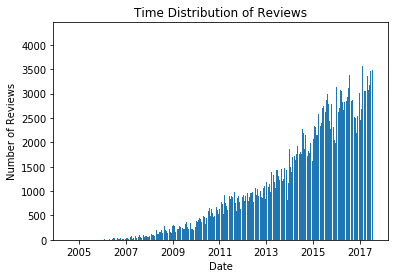

In [283]:
plt.bar(counts.index, counts)
plt.title("Time Distribution of Reviews")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.savefig("../shared/figures/distribution_of_reviews_over_time", dpi=400)
plt.show()

In [10]:
EARLIEST_DATE = "2016-08-23"
reviewSubset = reviews[reviews.date > EARLIEST_DATE]

In [397]:
reviewSubset.unique_id = (reviewSubset.user_id + reviewSubset.business_id)

In [12]:
print("There are %s reviews in the data after only "
       "considering reviews performed after %s" % (
           len(reviewSubset) ,EARLIEST_DATE))

There are 1000277 reviews in the data after only considering reviews performed after 2016-08-23


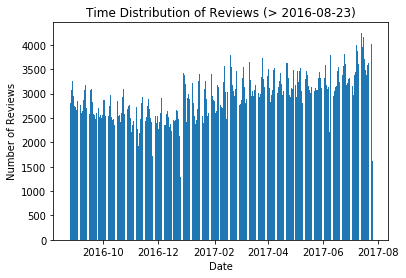

In [13]:
reviewSubsetcounts = reviewSubset.date.value_counts(sort=False)
plt.bar(reviewSubsetcounts.index, reviewSubsetcounts)
plt.title("Time Distribution of Reviews (> 2016-08-23)")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.savefig("../shared/figures/distribution_of_reviews_subset_over_time", dpi=400)
plt.show()

In [399]:
nUsers = len(set(reviewSubset.user_id))

In [400]:
nBusinesses = len(set(reviewSubset.business_id))

In [401]:
userToNodeId = {d :i for i, d in enumerate(set(reviewSubset.user_id))}

In [402]:
businessToNodeId = {d :i for i, d in enumerate(set(reviewSubset.business_id))}

In [407]:
# Split roughly into 60%, 20%, and 20%.
def getSplitSets(r):
    ''' returns train, validation, and test reviews'''
    t0 = '2016-08-24'
    t1 = '2017-03-28'
    t2 = '2017-05-29'
    t,v, test = (r[(r.date >= t0) & (r.date < t1)],
            r[(r.date >= t1) & (r.date < t2)],
            r[r.date >= t2])
    return t,v,test

In [408]:
train, validation, test = getSplitSets(reviewSubset)

In [409]:
nReviews = float(len(reviewSubset))
print("The train, val, test proportions are %s. " % ((len(train)/nReviews, len(validation)/nReviews, len(test)/nReviews))

(0.5989670861171456, 0.1991958227570963, 0.20183709112575818)

In [410]:
len(train)

599133

In [411]:
users = set(train.user_id)
businesses = set(train.business_id)
print "Number of users in train: %s" % len(users)
print "Number of businesses in train: %s" % len(businesses)

Number of users in train: 283085
Number of businesses in train: 92064


In [412]:
trueValidation = validation[validation.user_id.isin(users)
                            & validation.business_id.isin(businesses)]
print "Number of users dropped %s." % (len(users) - len(set(trueValidation.user_id)))
print "Number of businesses dropped %s." % (len(businesses) - len(set(trueValidation.business_id)))
print "Number of users in validation %s." % len(set(trueValidation.user_id))
print "Number of businesses in validation %s." % len(set(trueValidation.business_id))

Number of users dropped 241944.
Number of businesses dropped 57739.
Number of users in validation 41141.
Number of businesses in validation 34325.


In [413]:
trueTest = test[test.user_id.isin(users)
                            & test.business_id.isin(businesses)]
print "Number of users dropped %s." % (len(users) - len(set(trueTest.user_id)))
print "Number of businesses dropped %s." % (len(businesses) - len(set(trueTest.business_id)))
print "Number of users in validation %s." % len(set(trueTest.user_id))
print "Number of businesses in validation %s." % len(set(trueTest.business_id))

Number of users dropped 247068.
Number of businesses dropped 60956.
Number of users in validation 36017.
Number of businesses in validation 31108.


In [414]:
n = float(len(train) + len(trueValidation) + len(trueTest))
len(train)/n, len(trueValidation)/n, len(trueTest)/n

(0.7873569864720307, 0.11574995203313787, 0.0968930614948314)

In [415]:
print "Number of nodes in train graph %s" % (len(users) + len(businesses))
print "Number of edges in train graph %s" % len(train)
print "Total number of possible edges %s" % (len(users) * len(businesses))
print "Percentage of edges in graph: %s" % (
    100*(len(users) + len(businesses))/float((len(users) * len(businesses))))

Number of nodes in train graph 375149
Number of edges in train graph 599133
Total number of possible edges 26061937440
Percentage of edges in graph: 0.00143945169412


In [416]:
print "Number of nodes in validation graph %s" % (
    len(set(trueValidation.user_id)) + len(set(trueValidation.business_id)))
print "Number of edges in validation graph %s" % len(trueValidation)

Number of nodes in validation graph 75466
Number of edges in validation graph 88079


In [417]:
print "Number of nodes in test graph %s" % (
    len(set(trueTest.user_id)) + len(set(trueTest.business_id)))
print "Number of edges in test graph %s" % len(trueTest)

Number of nodes in test graph 67125
Number of edges in test graph 73730


In [418]:
# Save the training, validation, and testing data frames.
train.to_csv(os.path.join(DATA_DIR, "reviews_train.csv"))
trueValidation.to_csv(os.path.join(DATA_DIR, "reviews_validation.csv"))
trueTest.to_csv(os.path.join(DATA_DIR, "reviews_test.csv"))

In [419]:
len(train)

599133

In [420]:
u_to_id = {d: i for i, d in enumerate(users)}
b_to_id = {d: i + len(users) for i, d in enumerate(businesses)}
id_to_u = {d: i for i, d in u_to_id.iteritems()}
id_to_b = {d: i for i, d in b_to_id.iteritems()}

In [421]:
# Generate the weights for the graphs.
weightsTrain = {(row.user_id, row.business_id) : row.stars
                for _, row in train.iterrows()}
weightsValidation = {(row.user_id, row.business_id) : row.stars
                for _, row in trueValidation.iterrows()}
weightsTest = {(row.user_id, row.business_id) : row.stars
                for _, row in trueTest.iterrows()}

In [422]:
# Create the actually snappy graphs.
import snap
def generateGraph(data):
    N = len(users) + len(businesses)
    M = len(data)
    G = snap.TUNGraph.New(N, M)
    for i in xrange(N):
        G.AddNode(i)
    for u,b in zip(data.user_id, data.business_id):
        G.AddEdge(u_to_id[u], b_to_id[b])
    
    assert G.GetNodes() == N
    assert G.GetEdges() == M
    
    return G

In [423]:
Gtrain = generateGraph(train)
Gval = generateGraph(trueValidation)
Gtest = generateGraph(trueTest)

In [424]:
snap.PlotSccDistr(Gtest,"destribution_gtest",
                  "G_{test}")

In [425]:
snap.PlotSccDistr(Gtest,"destribution_gtrain",
                  "G_{train}")

In [426]:
snap.PlotSccDistr(Gtest,"destribution_gval",
                  "G_{val}")

In [427]:
snap.PlotOutDegDistr(Gtest,"degree_gtest",
                  "G_{test}", False, True)

In [428]:
snap.PlotOutDegDistr(Gtrain,"degree_gtrain",
                  "G_{train}",  False, True)

In [429]:
snap.PlotOutDegDistr(Gval,"degree_gval",
                  "G_{val}",  False, True)

In [446]:
import sys
def extractFeatures(G, data, N):
    ''' Returns dictionary of features for (u,v)'''
    results = {}
    user_to_rating = {u_to_id[row.user_id] : row.stars
                      for _, row in data.iterrows()}
    print "Finished star for user"
    sys.stdout.flush()
    business_to_rating = {b_to_id[row.business_id] : row.stars 
                          for _, row in data.iterrows()}
    print "finished stars for business"
    sys.stdout.flush()
    
    averageSentRate = {}
    averateReceivedRate = {}
    count = 0
    for _, row in data.iterrows():
        count += 1
        if (count % 10000 == 0):
            print "finished %s samples." % count
            sys.stdout.flush()
            
        features = []
        user = G.GetNI(u_to_id[row.user_id])
        business = G.GetNI(b_to_id[row.business_id])
        
        
        ratedbyu = [G.GetNI(user.GetNbrNId(i))
                    for i in xrange(user.GetDeg())]
        ratedb = [G.GetNI(business.GetNbrNId(i))
                  for i in xrange(business.GetDeg())]
        raters = [G.GetNI(b.GetNbrNId(i)) for b in ratedbyu
                  for i in xrange(b.GetDeg())]
        bus = [G.GetNI(u.GetNbrNId(i)) for u in ratedb
               for i in xrange(u.GetDeg())]
        
        idratedbyu = set([n.GetId() for n in ratedbyu])
        idbus = set(n.GetId() for n in bus)
        idratedb = set([n.GetId() for n in ratedb])
        idraters = set(n.GetId() for n in raters)
        
        commonRaters = idratedb & idraters
        commonBusinesses = idratedbyu & idbus
        features.append(len(commonRaters))
        features.append(len(commonBusinesses))
        features.append(np.mean([user_to_rating[r]
                                 for r in commonRaters]))
        features.append(np.mean([business_to_rating[b]
                                 for b in commonBusinesses]))
        features.append(np.mean([1.0 / user_to_rating[r]
                                 for r in commonRaters]))
        features.append(np.mean([1.0 / business_to_rating[b]
                                 for b in commonBusinesses]))

        
        if user.GetId() not in averageSentRate:
            averageSentRate[user.GetId()] = np.mean([business_to_rating[b]
                                                     for b in idratedbyu])
        if business.GetId() not in averateReceivedRate:
            averateReceivedRate[business.GetId()] = np.mean([user_to_rating[u]
                                                             for u in idratedb])
        features.append(
            averageSentRate[user.GetId()] * averateReceivedRate[business.GetId()])
        
        results[(user.GetId(), business.GetId())] = features

        
    # Get page ranks.
    PRankH = snap.TIntFltH()
    snap.GetPageRank(G, PRankH)
    NIdEigenH = snap.TIntFltH()
    snap.GetEigenVectorCentr(G, NIdEigenH)
    matrix = []
    pair_to_node = {}
    i = 0
    for key in results:
        u,b = key
        results[key].append(PRankH[u] + PRankH[b])
        results[key].append(NIdEigenH[u] + NIdEigenH[b])
        matrix.append(results[key])
        pair_to_node[key] = i
        i += 1
        
    feats = np.array(matrix)
    feats = (feats - np.mean(feats, axis=0)) / np.std(feats, axis=0)
    
    return pair_to_node, feats

In [447]:
def fixKeys(keys):
    if (min(keys.values()) == 1):
        return {k: v - 1 for k,v in keys.iteritems()}
    else:
        return keys

In [431]:
%%time
testKeys, testFeautures = extractFeatures(Gtest, trueTest, len(trueTest))

Finished star for user
finished stars for business
finished 10000 samples.
finished 20000 samples.
finished 30000 samples.
finished 40000 samples.
finished 50000 samples.
finished 60000 samples.
finished 70000 samples.
CPU times: user 46.3 s, sys: 830 ms, total: 47.1 s
Wall time: 49 s


In [449]:
testKeys = fixKeys(testKeys)

In [450]:
with open(os.path.join(DATA_DIR, "test_features.pkl"), "w") as f:
    pickle.dump((testKeys, testFeautures), f)

In [433]:
%%time
valKeys, valFeatures = extractFeatures(Gval, trueValidation, len(trueValidation))

Finished star for user
finished stars for business
finished 10000 samples.
finished 20000 samples.
finished 30000 samples.
finished 40000 samples.
finished 50000 samples.
finished 60000 samples.
finished 70000 samples.
finished 80000 samples.
CPU times: user 59.8 s, sys: 1.07 s, total: 1min
Wall time: 1min 2s


In [451]:
valKeys = fixKeys(valKeys)

In [452]:
with open(os.path.join(DATA_DIR, "val_features.pkl"), "w") as f:
    pickle.dump((valKeys, valFeatures), f)

In [435]:
trainKeys, trainFeatures = extractFeatures(Gtrain, train, len(train))

Finished star for user
finished stars for business
finished 10000 samples.
finished 20000 samples.
finished 30000 samples.
finished 40000 samples.
finished 50000 samples.
finished 60000 samples.
finished 70000 samples.
finished 80000 samples.
finished 90000 samples.
finished 100000 samples.
finished 110000 samples.
finished 120000 samples.
finished 130000 samples.
finished 140000 samples.
finished 150000 samples.
finished 160000 samples.
finished 170000 samples.
finished 180000 samples.
finished 190000 samples.
finished 200000 samples.
finished 210000 samples.
finished 220000 samples.
finished 230000 samples.
finished 240000 samples.
finished 250000 samples.
finished 260000 samples.
finished 270000 samples.
finished 280000 samples.
finished 290000 samples.
finished 300000 samples.
finished 310000 samples.
finished 320000 samples.
finished 330000 samples.
finished 340000 samples.
finished 350000 samples.
finished 360000 samples.
finished 370000 samples.
finished 380000 samples.
finished

In [453]:
trainKeys = fixKeys(trainKeys)

In [454]:
with open(os.path.join(DATA_DIR, "train_features.pkl"), "w") as f:
    pickle.dump((trainKeys, trainFeatures), f)

In [455]:
# Contruct the ratings resultsd
def extractRatings(data, mapping):
    res = np.zeros(len(mapping))
    for _, row in data.iterrows():
        res[mapping[(u_to_id[row.user_id], b_to_id[row.business_id])]
           ] = row.stars
    return res

In [457]:
yTest = extractRatings(trueTest, testKeys)
yTrain = extractRatings(train, trainKeys)
yVal = extractRatings(trueValidation, valKeys)

In [462]:
# dump to pickle
with open(os.path.join(DATA_DIR, "test_rating.pkl"), "w") as ftest, \
      open(os.path.join(DATA_DIR, "train_rating.pkl"), "w") as ftrain, \
      open(os.path.join(DATA_DIR, "val_rating.pkl"), "w") as fval:
    pickle.dump(yTest, ftest)
    pickle.dump(yTrain, ftrain)
    pickle.dump(yVal, fval)

In [45]:
users.yelping_since = pd.to_datetime(users.yelping_since)

In [46]:
sum(users.review_count == 0)

1256

In [53]:
# Remove users with no reviews
usersReviewedAtLeastOnce = users[users.review_count != 0]

In [54]:
userDateCounts = usersReviewedAtLeastOnce.yelping_since.value_counts(sort=False)

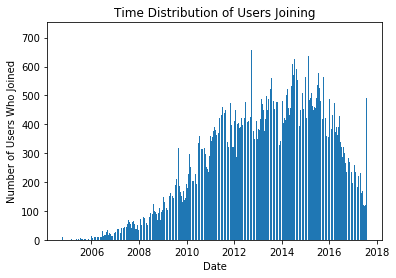

In [55]:
plt.bar(userDateCounts.index, userDateCounts)
plt.title("Time Distribution of Users Joining")
plt.xlabel("Date")
plt.ylabel("Number of Users Who Joined")
plt.savefig("../shared/figures/distribution_of_users_joining_over_time", dpi=400)
plt.show()